In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
from scipy.stats import mode
import csv
import matplotlib.dates
from datetime import *
from sklearn import linear_model
from sklearn.preprocessing import *
from sklearn import ensemble
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.externals import joblib
from fbprophet import Prophet

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
#导入训练数据
train_data = pd.read_csv('prophet_fusai_B_fullfilling_train_feature_set.csv')

print(train_data.head(10))

   date  brand  cnt  day_of_week  week  guess_date  date_year  date_month  \
0     1      1   31            2     0  2013-01-01       2013           1   
1     1      6    6            2     0  2013-01-01       2013           1   
2     1      9   15            2     0  2013-01-01       2013           1   
3     2      9    0            3     0  2013-01-02       2013           1   
4     2      8    0            3     0  2013-01-02       2013           1   
5     2      3    0            3     0  2013-01-02       2013           1   
6     2      2    0            3     0  2013-01-02       2013           1   
7     2      7   30            3     0  2013-01-02       2013           1   
8     2      6    6            3     0  2013-01-02       2013           1   
9     2      4   20            3     0  2013-01-02       2013           1   

   date_property guess_date_str    ...     brand_1 brand_2  brand_3  brand_4  \
0              2     2013-01-01    ...           1       0        0     

In [4]:
#根据prophet定义训练集
df_allBrand = train_data
df_allBrand['guess_date'] = df_allBrand['guess_date'].map(lambda x: datetime.strptime(x, "%Y-%m-%d"))
df_allBrand.rename(columns = {'guess_date':'ds', 'cnt':'y', 'brand':'brand'}, inplace=True)

In [5]:
#为模型添加节假日特征
#元旦
NewYearDay = pd.DataFrame({
  'holiday': 'NewYearDay',
  'ds': pd.to_datetime(['2013-01-01', '2013-01-02', '2013-01-03',
                        '2014-01-01', 
                        '2015-01-01', '2015-01-02', '2015-01-03',
                        '2016-01-01', '2016-01-02', '2016-01-03',
                        '2016-12-31', '2017-01-02', '2017-01-01'])
})

#春节
ChineseNewYearDay = pd.DataFrame({
  'holiday': 'ChineseNewYearDay',
  'ds': pd.to_datetime(['2013-02-09', '2013-02-10', '2013-02-11', '2013-02-12', '2013-02-13', '2013-02-14', '2013-02-15',
                        '2014-01-31', '2014-02-01', '2014-02-03', '2014-02-04', '2014-02-05', '2014-02-06', '2014-05-02', 
                        '2015-02-18', '2015-02-19', '2015-02-20', '2015-02-21', '2015-02-22', '2015-02-23', '2015-02-24',
                        '2016-02-07', '2016-02-08', '2016-02-09', '2016-02-10', '2016-02-11', '2016-02-12', '2016-02-13',
                       '2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01', '2017-02-02'])
})

#国庆节
NationalDay = pd.DataFrame({
  'holiday': 'NationalDay',
  'ds': pd.to_datetime(['2013-10-01', '2013-10-02', '2013-10-03', '2013-10-04', '2013-10-05', '2013-10-06', '2013-10-07',
                        '2014-10-01', '2014-10-02', '2014-10-03', '2014-10-04', '2014-10-05', '2014-10-06', '2014-10-07', 
                        '2015-10-01', '2015-10-02', '2015-10-03', '2015-10-04', '2015-10-05', '2015-10-06', '2015-10-07',
                        '2016-10-01', '2016-10-02', '2016-10-03', '2016-10-04', '2016-10-05', '2016-10-06', '2016-10-07',
                       '2017-10-01', '2017-10-02', '2017-10-03', '2017-10-04', '2017-10-05', '2017-10-06', '2017-10-07', 
                       '2017-10-08'])
})

#劳动节
MayDay = pd.DataFrame({
  'holiday': 'MayDay',
  'ds': pd.to_datetime(['2013-04-29', '2013-04-30', '2013-05-01',
                        '2014-05-01', '2014-05-02', '2014-05-03',  
                        '2015-05-01', '2015-05-02', '2015-05-03',
                        '2016-05-01', '2016-05-02', '2016-04-30',
                       '2017-04-29', '2017-04-30', '2017-05-01'])
})

#清明节
ChingMingDay = pd.DataFrame({
  'holiday': 'ChingMingDay',
  'ds': pd.to_datetime(['2013-04-04', '2013-04-05', '2013-04-06',
                        '2014-04-05', '2014-04-06', '2014-04-07',  
                        '2015-04-04', '2015-04-05', '2015-04-06',
                        '2016-04-02', '2016-04-03', '2016-04-04',
                       '2017-04-02', '2017-04-03', '2017-04-04'])
})

#端午节
DragonBoatDay = pd.DataFrame({
  'holiday': 'DragonBoatDay',
  'ds': pd.to_datetime(['2013-06-10', '2013-06-11', '2013-06-12',
                        '2014-05-31', '2014-06-01', '2014-06-02',  
                        '2015-06-20', '2015-06-21', '2015-06-22',
                        '2016-06-09', '2016-06-10', '2016-06-11',
                       '2017-05-28', '2017-05-29', '2017-05-30'])
})

#中秋节
MidAutumnDay = pd.DataFrame({
  'holiday': 'MidAutumnDay',
  'ds': pd.to_datetime(['2013-09-19', '2013-09-20', '2013-09-21',
                        '2014-09-06', '2014-09-07', '2014-09-08',  
                        '2015-09-26', '2015-09-27',
                        '2015-09-03', '2015-09-04', '2015-09-05',
                        '2016-09-15', '2016-09-16', '2016-09-17'])
})

holidays = pd.concat((NewYearDay, ChineseNewYearDay, NationalDay, MayDay, ChingMingDay, DragonBoatDay, MidAutumnDay))

In [6]:
#导入预测数据集
test_data = pd.read_csv('prophet_fusai_B_fullfilling_test_feature_set.csv')
test_data['guess_date'] = test_data['guess_date'].map(lambda x: datetime.strptime(x, "%Y-%m-%d"))
test_data.rename(columns = {'guess_date':'ds'}, inplace=True)


In [7]:
#定义根据date_property是否为0，预测数据的函数
def predictByProphet(df_train, df_test, holidays, cap, floor, none_value, changepoint_prior_scale,
                            interval_width, regressor_set, changepoints):
    #处理训练集相关数据
    df_train['y'] = df_train['y'].map(lambda x: None if x > none_value else x)
    #定义最大值和最小值
    df_train['cap'] = cap
    df_train['floor'] = floor
    
    #定义prophet模型和预测集
    m = Prophet(growth = 'logistic', holidays = holidays, changepoints = changepoints,
                changepoint_prior_scale = changepoint_prior_scale, interval_width = interval_width)
    m.add_seasonality(name = 'weekly', period = 7, fourier_order = 3)
    
    #添加额外特征
    for regressor_future in regressor_set:
        m.add_regressor(regressor_future)
        
    m.fit(df_train)
    
    #处理测试集相关数据
    test_data = pd.concat([df_train.drop('y', 1), df_test])
    test_data['cap'] = cap
    test_data['floor'] = floor
    
    forcast = m.predict(test_data)
    return m, forcast

df_brand9_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 9) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand9_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay', 'after_restday_one',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand9_changepoints_restday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand9_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 9) & (test_data.date_property != 0)]
m_brand9_restday, forcast_brand9_restday = predictByProphet(df_brand9_restday, test_data_brand9_restday, holidays, 500, -500, 500, 0.5,
                0.95, df_brand9_restday_regressor_set, brand9_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower  yhat_upper
432 2016-10-01   44.072431  -56.607077  143.118909
433 2016-10-02  -53.232394 -153.766391   46.775562
434 2016-10-03    3.119568  -97.328633  114.222874
435 2016-10-04   13.896408  -87.487337  116.372185
436 2016-10-05   29.726262  -76.113125  128.351073
437 2016-10-06   24.215714  -73.160590  128.212352
438 2016-10-07   15.062509  -89.621523  118.030249
439 2016-10-15  130.354040   35.547297  234.461864
440 2016-10-22  138.426133   30.303504  237.648144
441 2016-10-29  136.784693   40.849026  233.900407
442 2016-10-30   37.907005  -69.688392  144.679236
443 2016-11-05  127.497476   27.740351  227.862595
444 2016-11-12  116.844779   21.934805  220.280326
445 2016-11-19  110.035043    5.164092  212.603516
446 2016-11-20   11.637509  -91.267380  107.376417
447 2016-11-26  109.183642    2.333855  214.736405
448 2016-12-03  114.824041   11.091551  220.879525
449 2016-12-10  126.923345   21.116913  224.508150
450 2016-12-17  143.357858   47

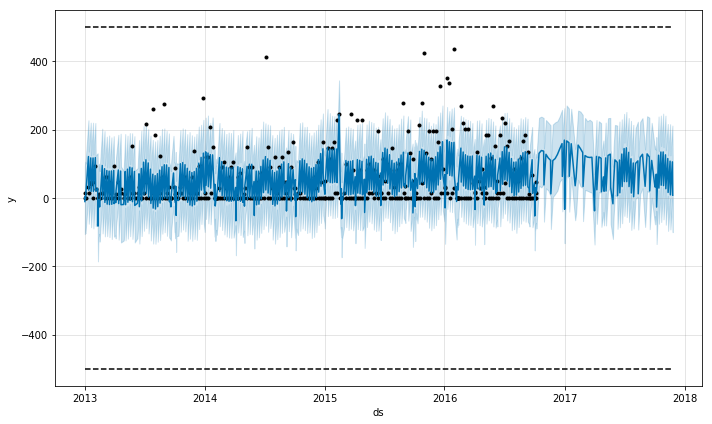

In [8]:
print(forcast_brand9_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand9_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand9_restday.ds < '2016-01-10') & (forcast_brand9_restday.ds > '2016-01-01')])
m_brand9_restday.plot(forcast_brand9_restday)

In [15]:
df_brand9_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 9) 
                                          & (train_data.date_property == 0)]
df_brand9_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand9_changepoints_workday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand9_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 9) & (test_data.date_property == 0)]
m_brand9_workday, forcast_brand9_workday = predictByProphet(df_brand9_workday, test_data_brand9_workday, holidays, 1400, -100, 1800, 0.5,
                0.95, df_brand9_workday_regressor_set, brand9_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat  yhat_lower   yhat_upper
1124 2017-07-06  523.771820   99.804141   959.348617
1125 2017-07-07  623.183779  175.867482  1069.363757
1126 2017-07-10  653.076816  182.941337  1074.588915
1127 2017-07-11  680.074513  176.172211  1150.683798
1128 2017-07-12  610.993406  177.805609  1044.257702
1129 2017-07-13  464.506876   -3.017286   905.317720
1130 2017-07-14  565.563151  108.054294   981.599492
1131 2017-07-17  605.987964  141.663288  1091.669570
1132 2017-07-18  637.962411  217.300646  1103.001257
1133 2017-07-19  574.350178  138.415615  1015.209323
1134 2017-07-20  433.663938   -0.542267   898.757634
1135 2017-07-21  540.686605   67.142630   985.482060
1136 2017-07-24  598.380489  112.923291  1066.827320
1137 2017-07-25  635.398788  188.555130  1098.660409
1138 2017-07-26  576.257079  128.129430   952.056266
1139 2017-07-27  439.365724   16.746140   870.093949
1140 2017-07-28  549.427916   93.464868   983.897541
1141 2017-07-31  611.286631  160.886365  1066.

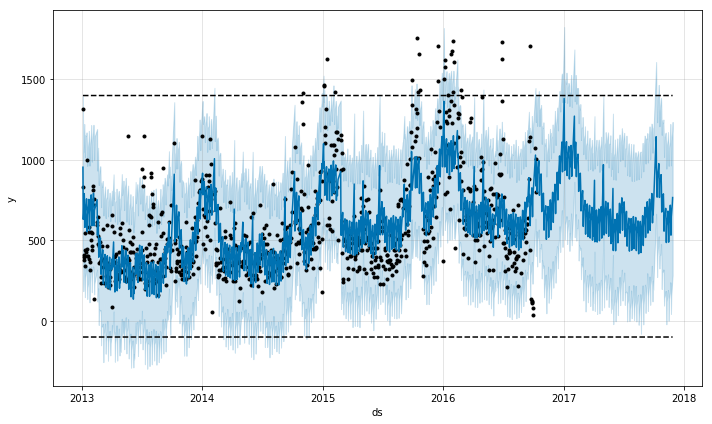

In [16]:
print(forcast_brand9_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand9_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand9_workday.ds < '2016-01-10') & (forcast_brand9_workday.ds > '2016-01-01')])
m_brand9_workday.plot(forcast_brand9_workday)

In [17]:
brand9_result = pd.concat([forcast_brand9_workday, forcast_brand9_restday])
brand9_result = brand9_result.sort_values(by='ds', ascending=True)
print(brand9_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

             ds        yhat  yhat_lower   yhat_upper
505  2017-08-13   11.760549  -92.821518   120.726671
1151 2017-08-14  588.405885  154.593463  1038.433034
1152 2017-08-15  621.112737  162.615095  1053.772798
1153 2017-08-16  557.733822  107.491258  1040.411985
1154 2017-08-17  416.920141  -23.976572   880.182106
1155 2017-08-18  523.604923   22.996200   958.426589
506  2017-08-19  118.616343   11.625948   222.621549
1156 2017-08-21  580.596902  121.165830  1045.566943
1157 2017-08-22  617.997069  165.902257  1048.176091
1158 2017-08-23  559.777063  119.994392  1052.179853
1159 2017-08-24  424.462378  -79.048934   891.714921
1160 2017-08-25  536.849906  108.744985   958.016508
507  2017-08-26  127.446433   28.165360   233.469256
1161 2017-08-28  610.735243  176.870721  1068.580121
1162 2017-08-29  653.221903  220.707437  1105.752876
1163 2017-08-30  599.597927  127.450062  1064.225575
1164 2017-08-31  468.277557  -21.696924   928.753403
1165 2017-09-01  583.964618   99.348531  1048.

In [24]:
df_brand1_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 1) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand1_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay', 'after_restday_one',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand1_changepoints_restday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand1_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 1) & (test_data.date_property != 0)]
m_brand1_restday, forcast_brand1_restday = predictByProphet(df_brand1_restday, test_data_brand1_restday, holidays, 300, -50, 200, 0.5,
                0.95, df_brand1_restday_regressor_set, brand1_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds       yhat  yhat_lower  yhat_upper
407 2016-07-09  62.293810    4.299993  119.560256
408 2016-07-10  20.841876  -37.568076   78.333770
409 2016-07-16  53.028288   -1.849701  110.265033
410 2016-07-17  11.532693  -43.976653   65.418463
411 2016-07-23  45.649142   -8.951412   96.673631
412 2016-07-24   4.793782  -51.553909   62.156985
413 2016-07-30  43.791844  -13.394544  100.020891
414 2016-07-31   3.806786  -48.646906   62.506394
415 2016-08-06  47.227350  -12.198275  105.341266
416 2016-08-07   7.750487  -49.899779   66.442800
417 2016-08-13  52.342678   -0.450586  108.777995
418 2016-08-14  12.749328  -40.454543   72.081739
419 2016-08-20  55.276047    0.187017  110.239213
420 2016-08-21  15.200756  -43.093275   70.783903
421 2016-08-27  55.011097    1.648282  111.160096
422 2016-08-28  14.605646  -37.508019   71.358637
423 2016-09-03  53.746966    0.374865  106.753217
424 2016-09-04  13.462475  -47.409015   65.521155
425 2016-09-10  54.406965    0.814405  107.999414


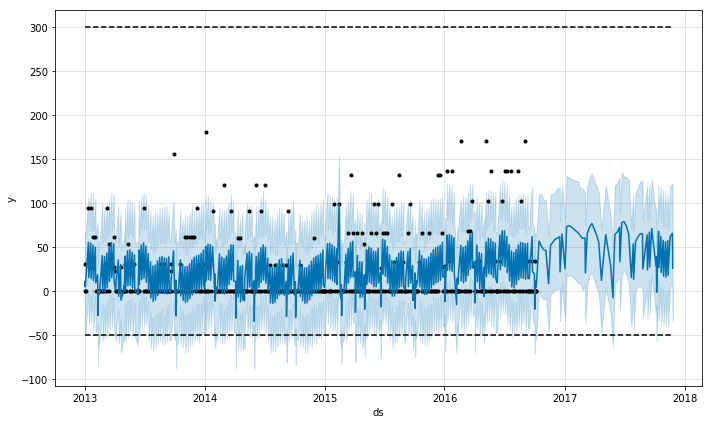

In [25]:
print(forcast_brand1_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand1_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand1_restday.ds < '2016-01-10') & (forcast_brand1_restday.ds > '2016-01-01')])
m_brand1_restday.plot(forcast_brand1_restday)

In [28]:
df_brand1_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 1) 
                                          & (train_data.date_property == 0)]
df_brand1_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand1_changepoints_workday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand1_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 1) & (test_data.date_property == 0)]
m_brand1_workday, forcast_brand1_workday = predictByProphet(df_brand1_workday, test_data_brand1_workday, holidays, 1500, -50, 1500, 0.5,
                0.95, df_brand1_workday_regressor_set, brand1_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat  yhat_lower  yhat_upper
1124 2017-07-06  360.495614   90.688276  665.343415
1125 2017-07-07  392.357631  126.947924  677.374539
1126 2017-07-10  464.261251  198.888014  723.863100
1127 2017-07-11  452.053178  188.999689  745.354720
1128 2017-07-12  405.154478  147.302546  646.035096
1129 2017-07-13  341.133399   75.685103  607.615319
1130 2017-07-14  368.747926   85.326759  633.867784
1131 2017-07-17  430.889730  165.523184  700.767209
1132 2017-07-18  416.639876  153.575664  683.728510
1133 2017-07-19  368.379671  114.511683  640.194727
1134 2017-07-20  303.698400   39.870980  569.341579
1135 2017-07-21  331.358588   66.503034  593.648288
1136 2017-07-24  397.673114  146.125715  650.397765
1137 2017-07-25  386.016286  116.746249  648.831397
1138 2017-07-26  340.844615   71.838824  602.415463
1139 2017-07-27  279.667264   23.018558  564.183088
1140 2017-07-28  311.158397   29.939700  584.118982
1141 2017-07-31  389.971826  112.376746  645.642220
1142 2017-08

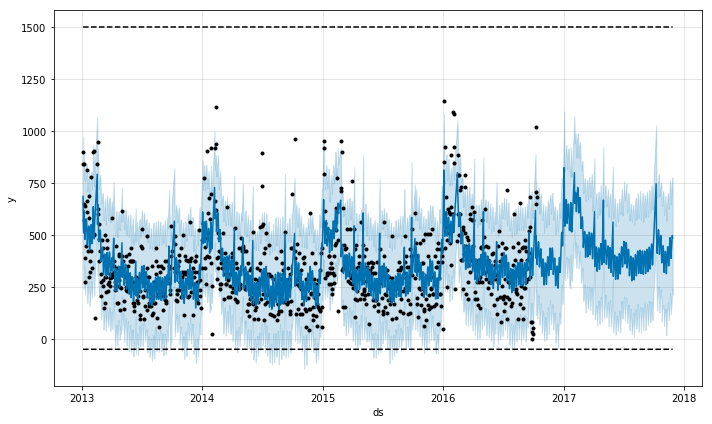

In [29]:
print(forcast_brand1_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand1_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand1_workday.ds < '2016-01-10') & (forcast_brand1_workday.ds > '2016-01-01')])
m_brand1_workday.plot(forcast_brand1_workday)

In [30]:
brand1_result = pd.concat([forcast_brand1_workday, forcast_brand1_restday])
brand1_result = brand1_result.sort_values(by='ds', ascending=True)
print(brand1_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

             ds        yhat  yhat_lower  yhat_upper
1149 2017-08-10  303.162797   49.614376  573.740914
1150 2017-08-11  338.282814   65.586113  601.968507
482  2017-08-12   61.455696    5.414295  118.488325
1151 2017-08-14  422.837562  167.499437  700.688205
1152 2017-08-15  415.582495  154.885318  696.967230
1153 2017-08-16  373.884215   92.459892  640.524719
1154 2017-08-17  315.235662   34.110101  582.943695
1155 2017-08-18  348.319199   95.514319  597.967859
483  2017-08-19   64.959910    5.741374  124.701286
1156 2017-08-21  426.710334  151.865474  711.546784
1157 2017-08-22  417.593085  153.285111  681.364488
1158 2017-08-23  374.218620   97.707482  639.963311
1159 2017-08-24  314.121570   26.175674  572.470262
1160 2017-08-25  346.016436   82.181143  623.841493
484  2017-08-26   65.176458    2.586825  124.578801
485  2017-08-27   24.799626  -30.839954   80.821464
1161 2017-08-28  422.569194  151.417768  673.490258
1162 2017-08-29  413.420500  130.450095  701.497413
1163 2017-08

In [31]:
df_brand2_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 2) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand2_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay', 'after_restday_one',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand2_changepoints_restday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand2_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 2) & (test_data.date_property != 0)]
m_brand2_restday, forcast_brand2_restday = predictByProphet(df_brand2_restday, test_data_brand2_restday, holidays, 500, -100, 200, 0.5,
                0.95, df_brand2_restday_regressor_set, brand2_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds       yhat  yhat_lower  yhat_upper
401 2016-06-19  13.179998  -39.433038   63.008641
402 2016-06-25  48.337652   -5.266880  100.591708
403 2016-06-26  12.323554  -40.273586   64.208030
404 2016-07-02  42.735181   -7.637711   92.847886
405 2016-07-03   6.165745  -45.057229   59.585113
406 2016-07-09  36.357113  -16.391784   89.257509
407 2016-07-10   0.328529  -54.091207   53.133870
408 2016-07-16  36.354569  -15.881416   88.852653
409 2016-07-17   1.508611  -49.604127   55.664704
410 2016-07-23  43.177876   -7.666152   93.297610
411 2016-07-24   8.774562  -42.132728   59.835339
412 2016-07-30  48.808291   -2.210371  100.754587
413 2016-07-31  13.451891  -40.614799   66.542056
414 2016-08-06  45.657108   -4.902150   99.086943
415 2016-08-07   8.964516  -45.069814   60.395152
416 2016-08-13  36.152693  -17.417914   83.982706
417 2016-08-14  -0.635064  -51.413207   53.765055
418 2016-08-20  31.036753  -20.312430   80.432188
419 2016-08-21  -4.301637  -56.750624   47.120470


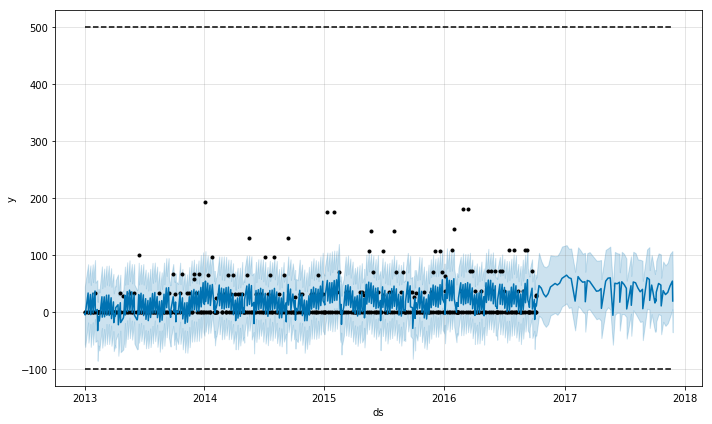

In [32]:
print(forcast_brand2_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand2_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand2_restday.ds < '2016-01-10') & (forcast_brand1_restday.ds > '2016-01-01')])
m_brand2_restday.plot(forcast_brand2_restday)

In [33]:
df_brand2_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 2) 
                                          & (train_data.date_property == 0)]
df_brand2_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand2_changepoints_workday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand2_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 2) & (test_data.date_property == 0)]
m_brand2_workday, forcast_brand2_workday = predictByProphet(df_brand2_workday, test_data_brand2_workday, holidays, 1500, -200, 800, 0.5,
                0.95, df_brand2_workday_regressor_set, brand2_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat  yhat_lower  yhat_upper
1124 2017-07-06  190.941442  -28.642563  396.708439
1125 2017-07-07  226.280878    7.753964  437.314610
1126 2017-07-10  251.910062   38.362378  459.091719
1127 2017-07-11  290.193769   83.637325  503.866089
1128 2017-07-12  260.851153   35.794133  485.281938
1129 2017-07-13  194.817689  -17.180281  413.286692
1130 2017-07-14  230.800123    7.376373  435.292576
1131 2017-07-17  258.715954   45.743320  475.373871
1132 2017-07-18  297.862803   83.605650  522.310034
1133 2017-07-19  269.420758   62.796609  489.132903
1134 2017-07-20  204.314911  -23.226686  427.835339
1135 2017-07-21  241.239834   32.958857  454.202568
1136 2017-07-24  271.924561   54.323765  476.787386
1137 2017-07-25  311.917748  105.930308  525.465340
1138 2017-07-26  284.252014   63.146393  511.404916
1139 2017-07-27  219.832180   -0.130580  432.132548
1140 2017-07-28  257.332281   35.029266  467.004043
1141 2017-07-31  288.878557   92.052102  478.050906
1142 2017-08

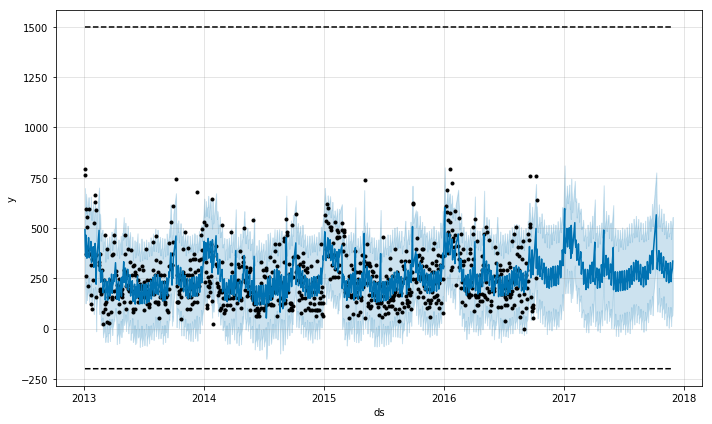

In [34]:
print(forcast_brand2_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand2_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand2_workday.ds < '2016-01-10') & (forcast_brand2_workday.ds > '2016-01-01')])
m_brand2_workday.plot(forcast_brand2_workday)

In [35]:
brand2_result = pd.concat([forcast_brand2_workday, forcast_brand2_restday])
brand2_result = brand2_result.sort_values(by='ds', ascending=True)
print(brand2_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

             ds        yhat  yhat_lower  yhat_upper
1146 2017-08-07  300.966937  113.975383  523.140958
1147 2017-08-08  339.350842  120.621443  560.117819
1148 2017-08-09  309.688399  106.821528  528.192079
1149 2017-08-10  242.894164   30.615372  456.827901
1150 2017-08-11  277.660274   63.815163  487.460666
479  2017-08-12   41.791053  -10.436825   91.881172
1151 2017-08-14  299.155661   74.027229  515.039371
1152 2017-08-15  335.265225  111.569296  544.463786
1153 2017-08-16  303.371485   87.677670  507.688001
1154 2017-08-17  234.432760   25.420640  434.190495
1155 2017-08-18  267.185200   48.704306  481.235154
480  2017-08-19   35.093285  -17.814968   91.224969
1156 2017-08-21  283.847439   62.349787  506.696374
1157 2017-08-22  318.876795   98.089960  529.169087
1158 2017-08-23  286.222607   65.214054  495.350753
1159 2017-08-24  216.868073   -4.330666  444.006168
1160 2017-08-25  249.568003   28.990037  457.058935
481  2017-08-26   39.373631  -16.842725   89.672191
482  2017-08

In [50]:
df_brand3_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 3) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand3_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay', 'after_restday_one',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand3_changepoints_restday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand3_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 3) & (test_data.date_property != 0)]
m_brand3_restday, forcast_brand3_restday = predictByProphet(df_brand3_restday, test_data_brand3_restday, holidays, 200, -300, 250, 0.5,
                0.95, df_brand3_restday_regressor_set, brand3_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower  yhat_upper
399 2016-06-11   47.747929   -9.719993  110.434059
400 2016-06-18   82.764920   19.040019  148.697446
401 2016-06-19   38.202549  -22.588350  100.829296
402 2016-06-25   86.738921   26.716721  145.718316
403 2016-06-26   41.619826  -24.619454  104.346539
404 2016-07-02   87.214553   25.709641  153.095216
405 2016-07-03   41.744437  -20.146906  101.740652
406 2016-07-09   86.329154   21.652553  146.133258
407 2016-07-10   40.852093  -24.610236  103.480027
408 2016-07-16   85.825560   30.321529  147.627966
409 2016-07-17   40.415942  -19.220318   99.105329
410 2016-07-23   85.291039   22.516548  145.321775
411 2016-07-24   39.761930  -24.567351  100.667256
412 2016-07-30   83.539540   23.884047  143.433056
413 2016-07-31   37.826090  -25.704750  102.272937
414 2016-08-06   81.227071   16.650441  144.375826
415 2016-08-07   35.636907  -22.122504   96.992705
416 2016-08-13   81.111146   18.180072  142.632072
417 2016-08-14   36.054459  -27

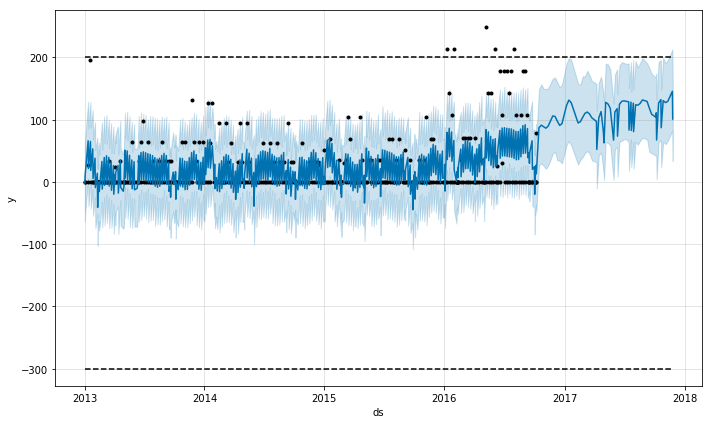

In [51]:
print(forcast_brand3_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand3_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand3_restday.ds < '2016-01-10') & (forcast_brand3_restday.ds > '2016-01-01')])
m_brand3_restday.plot(forcast_brand3_restday)

In [52]:
df_brand3_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 3) 
                                          & (train_data.date_property == 0)]
df_brand3_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand3_changepoints_workday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand3_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 3) & (test_data.date_property == 0)]
m_brand3_workday, forcast_brand3_workday = predictByProphet(df_brand3_workday, test_data_brand3_workday, holidays, 1500, -100, 1000, 0.5,
                0.95, df_brand3_workday_regressor_set, brand3_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat  yhat_lower  yhat_upper
1124 2017-07-06  140.505879  -95.751628  370.329211
1125 2017-07-07  182.672887  -35.108385  419.273651
1126 2017-07-10  239.978657   11.782096  461.555529
1127 2017-07-11  248.036229   17.718807  478.297888
1128 2017-07-12  206.564544  -12.127177  436.699108
1129 2017-07-13  145.153494  -99.227483  384.721673
1130 2017-07-14  186.214371  -33.431590  413.384087
1131 2017-07-17  239.673832   18.626772  492.289851
1132 2017-07-18  246.366393   43.186096  477.313430
1133 2017-07-19  203.539837  -10.747253  453.748023
1134 2017-07-20  140.816395  -86.315192  363.724827
1135 2017-07-21  180.639433  -52.015663  401.823265
1136 2017-07-24  231.131477   -3.500417  456.801991
1137 2017-07-25  237.170168   20.439931  470.690873
1138 2017-07-26  193.891585  -25.092367  428.059980
1139 2017-07-27  130.931756  -96.222159  371.810064
1140 2017-07-28  170.742712  -59.954040  403.074766
1141 2017-07-31  222.549006    4.008024  454.847996
1142 2017-08

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


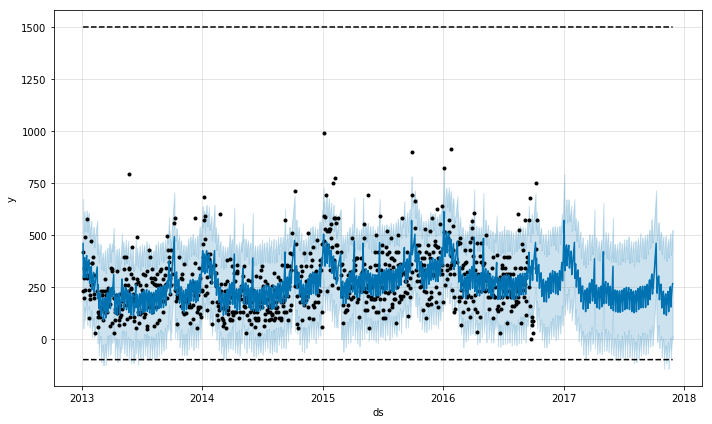

In [53]:
print(forcast_brand3_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand3_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand3_workday.ds < '2016-01-10') & (forcast_brand3_workday.ds > '2016-01-01')])
m_brand3_workday.plot(forcast_brand3_workday)

In [54]:
brand3_result = pd.concat([forcast_brand3_workday, forcast_brand3_restday])
brand3_result = brand3_result.sort_values(by='ds', ascending=True)
print(brand3_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

             ds        yhat  yhat_lower  yhat_upper
1142 2017-08-01  229.449894   -5.890939  466.836887
1143 2017-08-02  187.219286  -35.323021  405.667967
1144 2017-08-03  125.470224 -116.895897  347.940027
1145 2017-08-04  166.627684  -66.287552  409.945090
481  2017-08-05  124.109029   64.699856  194.091237
1146 2017-08-07  222.971306  -12.837339  468.317974
1147 2017-08-08  231.435448  -17.971271  472.625443
1148 2017-08-09  190.734275  -47.673500  412.568375
1149 2017-08-10  130.446240 -111.895715  372.660578
1150 2017-08-11  172.963635  -57.644603  409.865178
482  2017-08-12  123.270790   59.810102  183.957845
1151 2017-08-14  232.499782   -5.006667  474.773405
1152 2017-08-15  241.659177   24.031221  484.230136
1153 2017-08-16  201.444450  -28.845078  439.368537
1154 2017-08-17  141.427646  -96.244025  369.834734
1155 2017-08-18  184.000430  -67.567949  421.901821
483  2017-08-19  126.343863   66.555161  191.281292
1156 2017-08-21  242.487454  -20.217937  477.200579
1157 2017-08

In [55]:
df_brand4_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 4) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand4_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay', 'after_restday_one',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand4_changepoints_restday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand4_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 4) & (test_data.date_property != 0)]
m_brand4_restday, forcast_brand4_restday = predictByProphet(df_brand4_restday, test_data_brand4_restday, holidays, 500, -100, 200, 0.5,
                0.95, df_brand4_restday_regressor_set, brand4_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower  yhat_upper
416 2016-08-13   63.527782   13.941407  112.039400
417 2016-08-14   12.617278  -34.223979   62.156097
418 2016-08-20   69.069448   20.489383  120.175104
419 2016-08-21   18.282176  -29.931946   67.134265
420 2016-08-27   74.278294   25.360322  125.099836
421 2016-08-28   23.186561  -26.259801   72.820343
422 2016-09-03   76.017441   25.176473  123.751967
423 2016-09-04   24.222520  -23.082693   75.784153
424 2016-09-10   72.680321   23.214123  122.488577
425 2016-09-11   20.254471  -26.721152   68.890340
426 2016-09-15   17.139266  -29.061795   65.652977
427 2016-09-16   14.776105  -33.925507   63.813184
428 2016-09-17   22.603732  -24.874613   74.006396
429 2016-09-24   63.379480   13.906082  115.627070
430 2016-09-25   11.764588  -38.547059   62.420323
431 2016-10-01   37.277920  -10.994398   85.967502
432 2016-10-02  -13.560657  -63.077809   37.412102
433 2016-10-03   22.347987  -24.643934   70.912638
434 2016-10-04   23.186000  -27

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


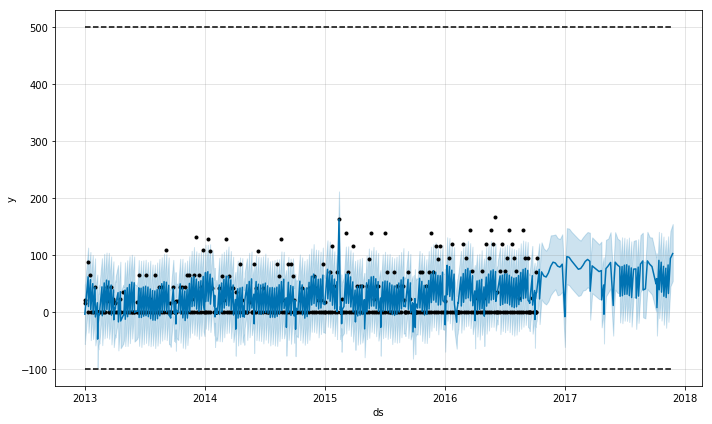

In [56]:
print(forcast_brand4_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand4_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand4_restday.ds < '2016-01-10') & (forcast_brand4_restday.ds > '2016-01-01')])
m_brand4_restday.plot(forcast_brand4_restday)

In [57]:
df_brand4_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 4) 
                                          & (train_data.date_property == 0)]
df_brand4_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand4_changepoints_workday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand4_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 4) & (test_data.date_property == 0)]
m_brand4_workday, forcast_brand4_workday = predictByProphet(df_brand4_workday, test_data_brand4_workday, holidays, 1500, -200, 1300, 0.5,
                0.95, df_brand4_workday_regressor_set, brand4_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat  yhat_lower  yhat_upper
1124 2017-07-06  275.262969    2.908642  565.021833
1125 2017-07-07  326.196929   46.295741  601.158474
1126 2017-07-10  444.943482  176.049660  707.555455
1127 2017-07-11  489.479586  189.166884  772.346965
1128 2017-07-12  388.319911  101.484152  660.322697
1129 2017-07-13  262.589655    9.762430  544.273272
1130 2017-07-14  312.812034   34.203024  590.107213
1131 2017-07-17  430.304360  168.305401  685.786637
1132 2017-07-18  474.766204  205.292595  771.025736
1133 2017-07-19  373.718528  100.470511  654.000604
1134 2017-07-20  248.287849  -16.887156  523.582248
1135 2017-07-21  298.993625   36.687509  574.736219
1136 2017-07-24  418.928449  161.114990  679.190796
1137 2017-07-25  464.476690  169.507547  717.048073
1138 2017-07-26  364.613511   90.505876  639.592917
1139 2017-07-27  240.438988  -31.803576  517.919089
1140 2017-07-28  292.444976   18.664013  588.643364
1141 2017-07-31  416.271646  133.366692  679.263311
1142 2017-08

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


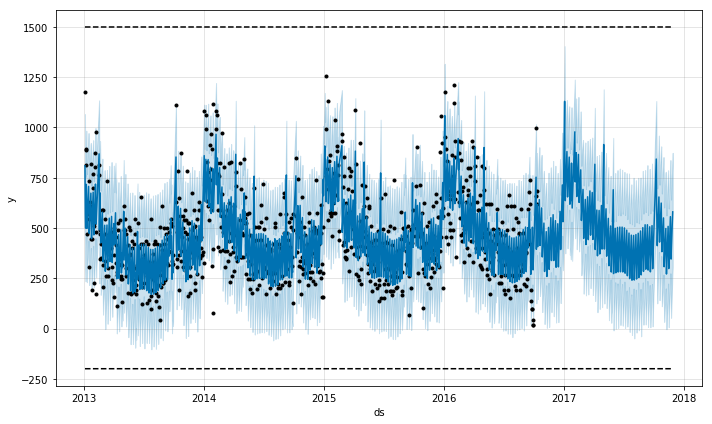

In [58]:
print(forcast_brand4_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand4_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand4_workday.ds < '2016-01-10') & (forcast_brand4_workday.ds > '2016-01-01')])
m_brand4_workday.plot(forcast_brand4_workday)

In [59]:
brand4_result = pd.concat([forcast_brand4_workday, forcast_brand4_restday])
brand4_result = brand4_result.sort_values(by='ds', ascending=True)
print(brand4_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

             ds        yhat  yhat_lower  yhat_upper
1149 2017-08-10  246.283913  -20.311214  527.551980
1150 2017-08-11  299.538749   31.150792  588.349254
491  2017-08-12   78.404097   24.799216  127.272062
492  2017-08-13   27.442731  -19.555124   77.893275
1151 2017-08-14  426.383458  158.231072  700.458742
1152 2017-08-15  473.991356  227.237793  749.577081
1153 2017-08-16  376.081469  123.605767  650.250385
1154 2017-08-17  253.770066   -8.666738  523.009182
1155 2017-08-18  307.568239   37.394515  576.820751
493  2017-08-19   83.733900   34.191264  134.398723
1156 2017-08-21  436.555112  146.841758  704.727003
1157 2017-08-22  485.027340  196.767339  751.037037
1158 2017-08-23  388.031739   94.039663  639.059591
1159 2017-08-24  266.660929  -38.960098  541.926135
1160 2017-08-25  321.397427   57.083462  609.083979
494  2017-08-26   89.232507   43.039948  138.822974
495  2017-08-27   38.231656   -9.877570   88.639027
1161 2017-08-28  452.845418  191.701465  725.718167
1162 2017-08

In [60]:
df_brand6_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 6) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand6_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay', 'after_restday_one',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand6_changepoints_restday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand6_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 6) & (test_data.date_property != 0)]
m_brand6_restday, forcast_brand6_restday = predictByProphet(df_brand6_restday, test_data_brand6_restday, holidays, 500, -100, 200, 0.5,
                0.95, df_brand6_restday_regressor_set, brand6_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds       yhat  yhat_lower  yhat_upper
427 2016-09-15   7.892689  -27.191016   42.839341
428 2016-09-16   8.903386  -25.882358   45.394052
429 2016-09-17  19.693782  -17.902002   52.778396
430 2016-09-24  46.502962   10.758814   80.557530
431 2016-09-25   6.750896  -29.412420   42.997747
432 2016-10-01  22.214072  -12.379773   55.271689
433 2016-10-02 -17.229584  -53.062363   18.029711
434 2016-10-03   7.383835  -26.564161   43.300960
435 2016-10-04  14.278662  -17.078294   49.572198
436 2016-10-05  19.415220  -15.737596   55.733343
437 2016-10-06  11.108118  -24.298517   44.075210
438 2016-10-07  12.754295  -23.916002   47.149219
439 2016-10-15  49.991728   14.352921   83.550285
440 2016-10-22  48.442913   11.965469   85.744619
441 2016-10-29  45.153861    9.417169   79.538696
442 2016-10-30   5.074171  -26.338018   40.408098
443 2016-11-05  43.471350    7.258132   78.848635
444 2016-11-12  45.168535   11.577284   78.665967
445 2016-11-19  47.876781   13.236092   83.527891


/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


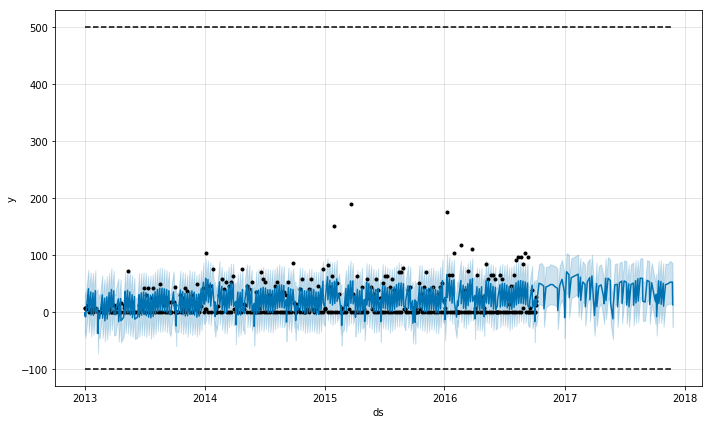

In [61]:
print(forcast_brand6_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand6_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand6_restday.ds < '2016-01-10') & (forcast_brand6_restday.ds > '2016-01-01')])
m_brand6_restday.plot(forcast_brand6_restday)

In [62]:
df_brand6_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 6) 
                                          & (train_data.date_property == 0)]
df_brand6_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand6_changepoints_workday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand6_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 6) & (test_data.date_property == 0)]
m_brand6_workday, forcast_brand6_workday = predictByProphet(df_brand6_workday, test_data_brand6_workday, holidays, 1000, -200, 700, 0.5,
                0.95, df_brand6_workday_regressor_set, brand6_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat  yhat_lower  yhat_upper
1124 2017-07-06  251.837832   88.773390  405.340345
1125 2017-07-07  289.313406  148.576579  429.426501
1126 2017-07-10  297.655521  147.374074  440.323699
1127 2017-07-11  325.446472  169.909748  476.418325
1128 2017-07-12  298.661400  148.808962  450.500260
1129 2017-07-13  250.383054   89.745438  399.149676
1130 2017-07-14  288.125241  136.857515  437.114000
1131 2017-07-17  298.026400  138.908835  455.156659
1132 2017-07-18  326.558852  171.506968  478.646473
1133 2017-07-19  300.602465  153.051662  444.239444
1134 2017-07-20  253.221526  106.333846  391.701956
1135 2017-07-21  291.909143  142.968019  441.596397
1136 2017-07-24  304.705324  144.961037  456.275927
1137 2017-07-25  334.142574  188.086479  471.201656
1138 2017-07-26  309.021535  165.087526  468.207390
1139 2017-07-27  262.384562  106.306411  416.509577
1140 2017-07-28  301.704809  150.816934  450.837354
1141 2017-07-31  315.572394  175.512198  465.788379
1142 2017-08

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


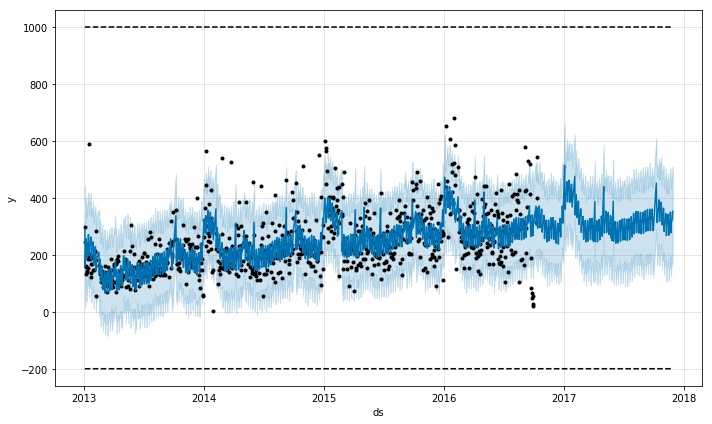

In [63]:
print(forcast_brand6_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand6_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand6_workday.ds < '2016-01-10') & (forcast_brand6_workday.ds > '2016-01-01')])
m_brand6_workday.plot(forcast_brand6_workday)

In [65]:
brand6_result = pd.concat([forcast_brand6_workday, forcast_brand6_restday])
brand6_result = brand6_result.sort_values(by='ds', ascending=True)
print(brand6_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

             ds        yhat  yhat_lower  yhat_upper
1150 2017-08-11  315.597675  166.062573  460.263706
501  2017-08-12   57.955751   20.503785   89.850305
502  2017-08-13   18.598689  -18.963172   55.207971
1151 2017-08-14  324.164003  166.425287  467.872346
1152 2017-08-15  351.781865  201.015714  491.433317
1153 2017-08-16  324.702143  178.318580  483.650896
1154 2017-08-17  276.012146  129.303830  424.132596
1155 2017-08-18  313.232172  165.584447  457.463957
503  2017-08-19   59.073644   25.982719   93.525930
1156 2017-08-21  320.993745  166.018915  470.523678
1157 2017-08-22  348.658684  204.342025  497.340300
1158 2017-08-23  321.778421  170.944548  467.321193
1159 2017-08-24  273.430593  127.187299  420.774756
1160 2017-08-25  311.121832  144.888769  474.216589
504  2017-08-26   58.392106   18.634995   94.004139
505  2017-08-27   18.553532  -16.165134   52.217339
1161 2017-08-28  320.884003  171.126747  471.604541
1162 2017-08-29  349.336172  185.950682  507.103502
1163 2017-08

In [66]:
df_brand7_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 7) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand7_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay', 'after_restday_one',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand7_changepoints_restday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand7_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 7) & (test_data.date_property != 0)]
m_brand7_restday, forcast_brand7_restday = predictByProphet(df_brand7_restday, test_data_brand7_restday, holidays, 500, -100, 200, 0.5,
                0.95, df_brand7_restday_regressor_set, brand7_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds       yhat  yhat_lower  yhat_upper
403 2016-06-26  13.240950  -44.151048   71.640966
404 2016-07-02  63.031266    3.139573  124.720023
405 2016-07-03  15.801904  -41.766824   72.798428
406 2016-07-09  68.983168   11.842603  131.472153
407 2016-07-10  21.736755  -37.410851   76.978422
408 2016-07-16  71.587770   11.351613  126.656012
409 2016-07-17  23.412049  -35.320604   80.042510
410 2016-07-23  67.708366    5.959568  123.861393
411 2016-07-24  18.841840  -42.124557   77.763644
412 2016-07-30  61.834373   -0.340994  118.837507
413 2016-07-31  13.249128  -44.548544   70.548833
414 2016-08-06  59.981257    2.020236  120.063324
415 2016-08-07  12.178665  -44.801218   73.975570
416 2016-08-13  62.656120    1.154925  122.461973
417 2016-08-14  15.167344  -44.293963   70.788366
418 2016-08-20  65.098258   10.363285  125.032982
419 2016-08-21  17.157740  -36.650227   76.268266
420 2016-08-27  63.374343    5.749912  122.070799
421 2016-08-28  14.800118  -40.859144   76.413150


/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


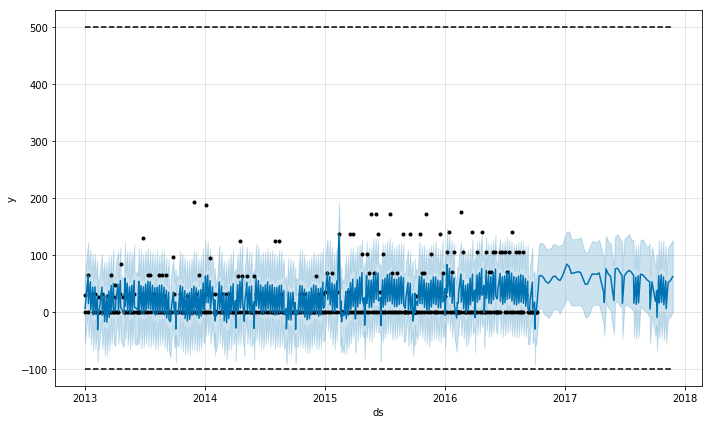

In [67]:
print(forcast_brand7_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand7_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand7_restday.ds < '2016-01-10') & (forcast_brand7_restday.ds > '2016-01-01')])
m_brand7_restday.plot(forcast_brand7_restday)

In [68]:
df_brand7_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 7) 
                                          & (train_data.date_property == 0)]
df_brand7_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand7_changepoints_workday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand7_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 7) & (test_data.date_property == 0)]
m_brand7_workday, forcast_brand7_workday = predictByProphet(df_brand7_workday, test_data_brand7_workday, holidays, 1000, -200, 750, 0.5,
                0.95, df_brand7_workday_regressor_set, brand7_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat  yhat_lower  yhat_upper
1124 2017-07-06  298.133465   64.972935  526.851679
1125 2017-07-07  338.118911  133.961051  567.565898
1126 2017-07-10  345.952849  114.284298  552.870449
1127 2017-07-11  389.632348  177.360693  641.022108
1128 2017-07-12  351.086922  131.256663  585.629131
1129 2017-07-13  301.662273   73.525066  525.253222
1130 2017-07-14  340.407735  103.590082  567.641689
1131 2017-07-17  344.164604  128.619084  564.271397
1132 2017-07-18  386.464035  155.476378  595.632838
1133 2017-07-19  346.577167  113.662242  563.889636
1134 2017-07-20  295.878056   75.379979  505.036819
1135 2017-07-21  333.442873  113.967946  550.520762
1136 2017-07-24  334.456669  106.484190  567.768506
1137 2017-07-25  376.173266  159.762929  615.084144
1138 2017-07-26  335.894244   99.517607  554.060359
1139 2017-07-27  285.003598   65.440358  514.915104
1140 2017-07-28  322.583978   93.142754  558.831823
1141 2017-07-31  324.900410   80.995030  561.147680
1142 2017-08

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


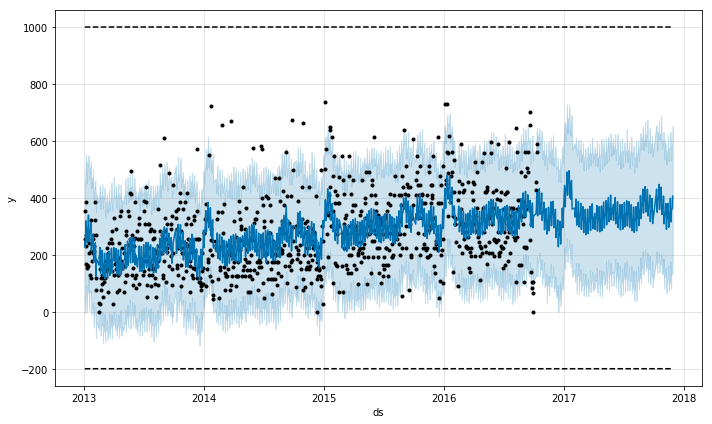

In [69]:
print(forcast_brand7_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand7_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand7_workday.ds < '2016-01-10') & (forcast_brand7_workday.ds > '2016-01-01')])
m_brand7_workday.plot(forcast_brand7_workday)

In [70]:
brand7_result = pd.concat([forcast_brand7_workday, forcast_brand7_restday])
brand7_result = brand7_result.sort_values(by='ds', ascending=True)
print(brand7_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

             ds        yhat  yhat_lower  yhat_upper
1147 2017-08-08  369.109267  144.454052  599.054435
1148 2017-08-09  331.766059  100.583433  563.372974
1149 2017-08-10  284.030946   38.369474  508.392456
1150 2017-08-11  324.948887  108.997946  545.084857
480  2017-08-12   63.006246    3.473802  118.957773
481  2017-08-13   15.523166  -44.871645   72.647267
1151 2017-08-14  337.962191  107.493937  564.947141
1152 2017-08-15  384.170438  160.175548  601.198609
1153 2017-08-16  348.542053  121.235014  575.245268
1154 2017-08-17  302.404578   80.454046  528.130753
1155 2017-08-18  344.782267  116.859974  556.998221
482  2017-08-19   65.887919    9.531019  126.376474
1156 2017-08-21  361.156452  118.531688  592.764779
1157 2017-08-22  408.088397  190.807394  627.566098
1158 2017-08-23  372.960773  125.264372  593.985440
1159 2017-08-24  327.089131  100.907124  570.759979
1160 2017-08-25  369.487921  144.799329  604.742319
483  2017-08-26   64.986412    5.249407  127.097676
1161 2017-08

In [71]:
df_brand8_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 8) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand8_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay', 'after_restday_one',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand8_changepoints_restday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand8_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 8) & (test_data.date_property != 0)]
m_brand8_restday, forcast_brand8_restday = predictByProphet(df_brand8_restday, test_data_brand8_restday, holidays, 500, -100, 200, 0.5,
                0.95, df_brand8_restday_regressor_set, brand8_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds       yhat  yhat_lower  yhat_upper
402 2016-06-25  53.338086    3.005829  103.651305
403 2016-06-26  25.303492  -19.199956   76.790976
404 2016-07-02  48.180680   -2.332415   97.058773
405 2016-07-03  19.598932  -27.409606   67.769888
406 2016-07-09  41.686129   -9.178976   93.323731
407 2016-07-10  13.415325  -37.304507   61.748612
408 2016-07-16  39.585671   -9.259748   89.882497
409 2016-07-17  12.259446  -39.534673   61.322281
410 2016-07-23  44.346369   -7.057080   90.745495
411 2016-07-24  17.906150  -30.877808   70.159503
412 2016-07-30  53.598891    4.809349  103.552776
413 2016-07-31  27.405628  -22.775338   79.548112
414 2016-08-06  62.305878   10.920573  110.680961
415 2016-08-07  35.635809  -11.571606   87.314543
416 2016-08-13  66.276830   18.576379  116.310413
417 2016-08-14  38.751499  -12.208413   88.121510
418 2016-08-20  64.235867   18.117775  113.221557
419 2016-08-21  35.921743  -13.826985   89.185662
420 2016-08-27  57.629829    6.908097  104.629954


/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


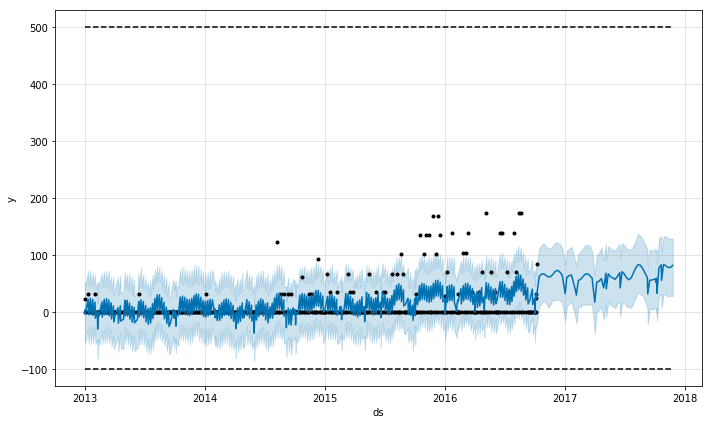

In [72]:
print(forcast_brand8_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand8_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand8_restday.ds < '2016-01-10') & (forcast_brand8_restday.ds > '2016-01-01')])
m_brand8_restday.plot(forcast_brand8_restday)

In [73]:
df_brand8_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 8) 
                                          & (train_data.date_property == 0)]
df_brand8_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand8_changepoints_workday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand8_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 8) & (test_data.date_property == 0)]
m_brand8_workday, forcast_brand8_workday = predictByProphet(df_brand8_workday, test_data_brand8_workday, holidays, 800, -300, 800, 0.5,
                0.95, df_brand8_workday_regressor_set, brand8_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat  yhat_lower  yhat_upper
1124 2017-07-06  393.379226  167.680411  622.101324
1125 2017-07-07  416.336148  189.801517  626.223097
1126 2017-07-10  479.709212  260.748426  699.966973
1127 2017-07-11  489.085651  279.408425  702.514370
1128 2017-07-12  460.723055  251.693637  676.516047
1129 2017-07-13  421.803999  199.901105  638.227402
1130 2017-07-14  444.248462  217.412773  652.379765
1131 2017-07-17  503.085979  278.554450  709.201885
1132 2017-07-18  510.051218  310.704678  725.220945
1133 2017-07-19  478.905643  244.132809  690.133108
1134 2017-07-20  436.893273  190.622610  648.263165
1135 2017-07-21  456.003497  235.476389  672.200810
1136 2017-07-24  504.171710  284.736663  729.986599
1137 2017-07-25  507.633310  263.535803  733.874388
1138 2017-07-26  473.148782  244.183031  677.767032
1139 2017-07-27  428.041392  179.756815  654.074975
1140 2017-07-28  444.374571  218.116494  665.471451
1141 2017-07-31  486.744868  262.318967  706.424762
1142 2017-08

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


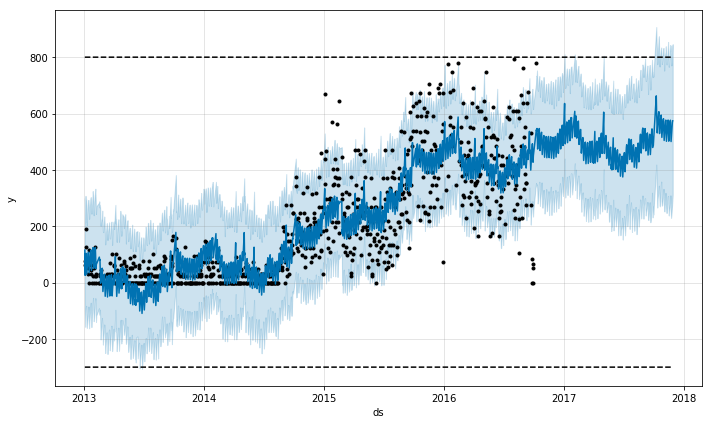

In [74]:
print(forcast_brand8_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand8_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand8_workday.ds < '2016-01-10') & (forcast_brand8_workday.ds > '2016-01-01')])
m_brand8_workday.plot(forcast_brand8_workday)

In [75]:
brand8_result = pd.concat([forcast_brand8_workday, forcast_brand8_restday])
brand8_result = brand8_result.sort_values(by='ds', ascending=True)
print(brand8_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

             ds        yhat  yhat_lower  yhat_upper
1145 2017-08-04  426.585025  203.539372  661.748531
481  2017-08-05   77.636186   25.359295  126.501721
1146 2017-08-07  474.379899  268.567780  690.136772
1147 2017-08-08  479.644077  260.624023  724.964384
1148 2017-08-09  447.882631  197.419540  685.441434
1149 2017-08-10  406.360097  171.782433  638.813337
1150 2017-08-11  427.060843  185.192553  667.534069
482  2017-08-12   82.627048   35.050635  136.838671
1151 2017-08-14  486.175960  248.367187  714.984970
1152 2017-08-15  495.083009  260.384019  718.360968
1153 2017-08-16  466.757898  237.201313  689.204631
1154 2017-08-17  428.386546  199.094191  658.452829
1155 2017-08-18  451.881466  223.147195  685.678834
483  2017-08-19   81.604157   30.407591  133.356110
1156 2017-08-21  516.654174  295.018180  747.656159
1157 2017-08-22  526.399021  286.460138  755.224308
1158 2017-08-23  498.348483  274.047358  722.577919
1159 2017-08-24  459.684593  227.622193  683.145084
1160 2017-08

In [76]:
df_brand10_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 10) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand10_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay', 'after_restday_one',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand10_changepoints_restday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand10_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 10) & (test_data.date_property != 0)]
m_brand10_restday, forcast_brand10_restday = predictByProphet(df_brand10_restday, test_data_brand10_restday, holidays, 500, -100, 180, 0.5,
                0.95, df_brand10_restday_regressor_set, brand10_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds       yhat  yhat_lower  yhat_upper
410 2016-07-23  45.198124    0.512339   95.405787
411 2016-07-24   0.485885  -45.195530   46.803071
412 2016-07-30  41.041285   -5.299660   88.250066
413 2016-07-31  -3.190895  -50.164958   42.135732
414 2016-08-06  40.754537   -4.953111   85.219084
415 2016-08-07  -2.941114  -47.571023   44.768873
416 2016-08-13  43.301204   -0.984194   88.490745
417 2016-08-14  -0.188906  -44.115271   45.302503
418 2016-08-20  46.496804    0.703973   91.267488
419 2016-08-21   3.010025  -42.118877   50.536680
420 2016-08-27  49.852571    3.694230   92.195278
421 2016-08-28   6.442390  -36.237330   53.810783
422 2016-09-03  53.849924    5.643227   99.860556
423 2016-09-04  10.487679  -33.189637   60.015133
424 2016-09-10  57.133241    8.597027  101.366849
425 2016-09-11  13.405427  -34.869798   58.846582
426 2016-09-15   3.906530  -45.052435   51.511559
427 2016-09-16   5.805073  -43.281481   53.826967
428 2016-09-17  16.781945  -27.318326   65.743922


/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


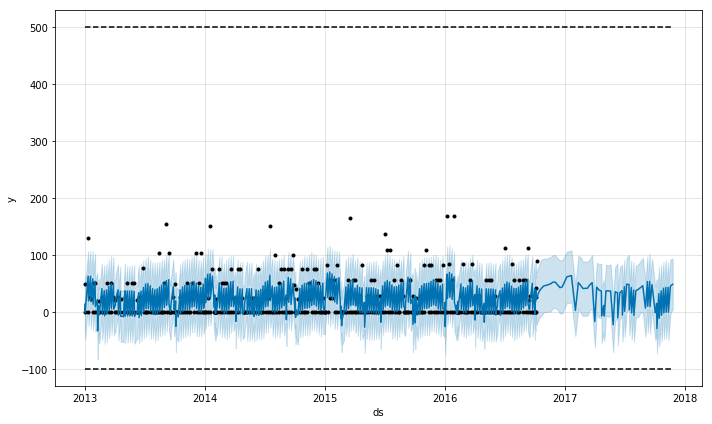

In [77]:
print(forcast_brand10_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand10_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand10_restday.ds < '2016-01-10') & (forcast_brand10_restday.ds > '2016-01-01')])
m_brand10_restday.plot(forcast_brand10_restday)

In [94]:
df_brand10_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 10) 
                                          & (train_data.date_property == 0)]
df_brand10_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand10_changepoints_workday = ['2013-10-01', '2014-10-01', '2015-10-01']
test_data_brand10_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 10) & (test_data.date_property == 0)]
m_brand10_workday, forcast_brand10_workday = predictByProphet(df_brand10_workday, test_data_brand10_workday, holidays, 2000, 1000, 2000, 0.5,
                0.95, df_brand10_workday_regressor_set, brand10_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat  yhat_lower  yhat_upper
1125 2017-07-06  109.514854 -221.755507  436.034593
1126 2017-07-07  178.523370 -162.291067  508.913490
1127 2017-07-10  260.802506  -73.581872  602.326136
1128 2017-07-11  239.481525  -98.371608  554.519353
1129 2017-07-12  198.955605 -133.301590  519.011308
1130 2017-07-13  109.501437 -216.365129  416.735147
1131 2017-07-14  174.405440 -138.081343  483.432192
1132 2017-07-17  246.305534  -65.176110  592.952714
1133 2017-07-18  222.421073 -104.557235  544.544295
1134 2017-07-19  179.880620 -129.898615  510.193998
1135 2017-07-20   89.003435 -260.109517  425.153156
1136 2017-07-21  153.105034 -189.440052  492.906882
1137 2017-07-24  226.398380 -111.119783  555.748286
1138 2017-07-25  204.198487 -148.958698  532.487440
1139 2017-07-26  163.894340 -149.337346  507.922548
1140 2017-07-27   75.750801 -275.300042  426.363777
1141 2017-07-28  143.017684 -172.216679  499.439681
1142 2017-07-31  227.603944 -103.142977  589.102431
1143 2017-08

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


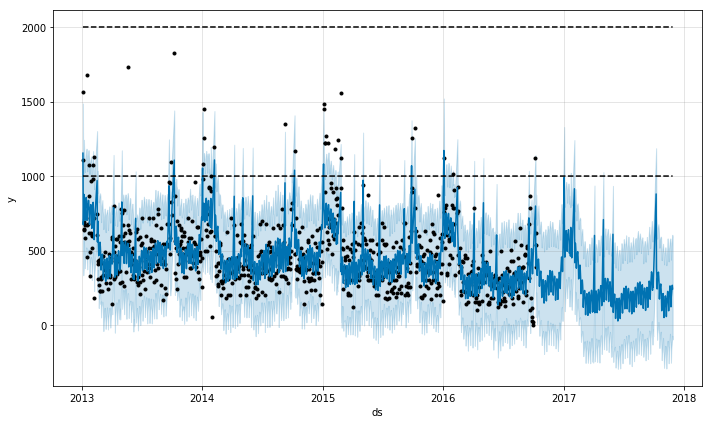

In [95]:
print(forcast_brand10_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand10_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand10_workday.ds < '2016-01-10') & (forcast_brand10_workday.ds > '2016-01-01')])
m_brand10_workday.plot(forcast_brand10_workday)

In [96]:
brand10_result = pd.concat([forcast_brand10_workday, forcast_brand10_restday])
brand10_result = brand10_result.sort_values(by='ds', ascending=True)
print(brand10_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

             ds        yhat  yhat_lower  yhat_upper
1150 2017-08-10  120.296731 -202.704803  475.126427
1151 2017-08-11  191.775506 -183.851097  545.667186
485  2017-08-12   39.229605   -9.254250   83.079796
1152 2017-08-14  283.284434  -19.932364  621.400003
1153 2017-08-15  265.370606  -46.113256  630.421155
1154 2017-08-16  228.269744 -106.843717  577.930168
1155 2017-08-17  142.168507 -192.301568  494.011397
1156 2017-08-18  210.265008 -120.572772  567.350344
486  2017-08-19   42.408747   -1.725455   88.795295
1157 2017-08-21  289.963960  -41.619697  614.894327
1158 2017-08-22  267.849502  -67.071909  582.456670
1159 2017-08-23  226.569359 -127.210190  577.755166
1160 2017-08-24  136.402964 -198.930764  484.824648
1161 2017-08-25  200.639003 -148.270545  545.161643
487  2017-08-26   45.691434   -0.617161   94.570631
1162 2017-08-28  270.819328  -57.330796  588.858086
1163 2017-08-29  246.462601  -94.271776  561.831987
1164 2017-08-30  203.504494 -103.007459  515.139346
1165 2017-08

In [97]:
df_brand5_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 5) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand5_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay', 'after_restday_one',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand5_changepoints_restday = ['2014-10-01', '2015-10-01']
test_data_brand5_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 5) & (test_data.date_property != 0)]
m_brand5_restday, forcast_brand5_restday = predictByProphet(df_brand5_restday, test_data_brand5_restday, holidays, 200, -100, 200, 0.5,
                0.95, df_brand5_restday_regressor_set, brand5_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower  yhat_upper
223 2016-06-05   10.026141  -41.411456   65.786795
224 2016-06-09    5.199169  -49.849530   56.356565
225 2016-06-10    6.323822  -46.514026   58.348563
226 2016-06-11   21.561508  -31.601731   76.536568
227 2016-06-18   53.912232   -1.388897  106.181351
228 2016-06-19   17.829527  -34.191762   71.385934
229 2016-06-25   61.790923   11.502917  120.485430
230 2016-06-26   25.649610  -24.712601   77.971450
231 2016-07-02   67.702948   12.363830  121.040967
232 2016-07-03   31.027221  -20.090777   81.703912
233 2016-07-09   69.174019    9.820177  124.637977
234 2016-07-10   31.805715  -17.212743   80.324747
235 2016-07-16   66.317388   12.559513  118.512100
236 2016-07-17   28.502148  -24.098316   82.542715
237 2016-07-23   61.777143    7.303378  114.636157
238 2016-07-24   24.015572  -28.365757   75.232494
239 2016-07-30   58.988363    6.712492  110.554612
240 2016-07-31   21.684657  -31.725963   78.420865
241 2016-08-06   59.694127    2

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


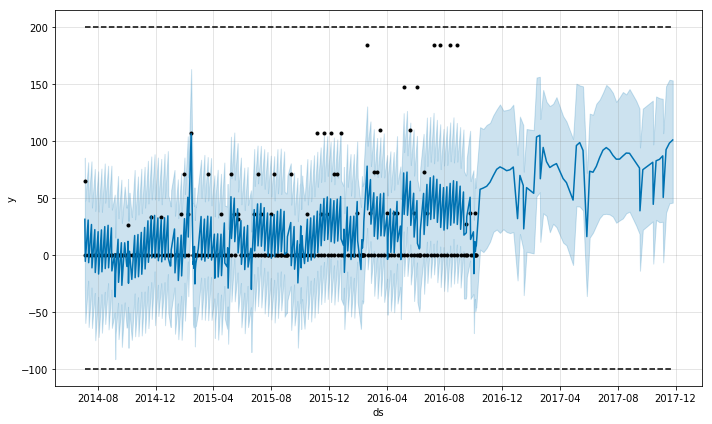

In [98]:
print(forcast_brand5_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand5_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand5_restday.ds < '2016-01-10') & (forcast_brand5_restday.ds > '2016-01-01')])
m_brand5_restday.plot(forcast_brand5_restday)

In [99]:
df_brand5_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 5) 
                                          & (train_data.date_property == 0)]
df_brand5_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand5_changepoints_workday = ['2014-10-01', '2015-10-01']
test_data_brand5_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 5) & (test_data.date_property == 0)]
m_brand5_workday, forcast_brand5_workday = predictByProphet(df_brand5_workday, test_data_brand5_workday, holidays, 1500, -100, 1500, 0.5,
                0.95, df_brand5_workday_regressor_set, brand5_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower   yhat_upper
749 2017-07-06  493.408375  210.700124   771.405069
750 2017-07-07  531.279540  261.740828   802.326076
751 2017-07-10  660.479365  375.753839   930.473798
752 2017-07-11  639.464725  365.091952   907.685323
753 2017-07-12  591.853384  304.840169   869.427025
754 2017-07-13  523.772864  247.698801   813.625860
755 2017-07-14  556.760068  290.692153   848.181195
756 2017-07-17  669.933909  399.975750   954.527625
757 2017-07-18  643.587661  366.869843   934.635523
758 2017-07-19  590.880979  315.278111   878.234586
759 2017-07-20  518.069980  251.849149   819.743392
760 2017-07-21  546.808403  279.002142   833.007482
761 2017-07-24  651.055365  364.268051   920.408246
762 2017-07-25  623.220424  332.101663   897.797508
763 2017-07-26  569.821988  307.492469   822.166290
764 2017-07-27  497.114708  232.664971   781.993470
765 2017-07-28  526.728707  255.283541   820.763382
766 2017-07-31  637.690072  349.138912   909.290019
767 2017-08-

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


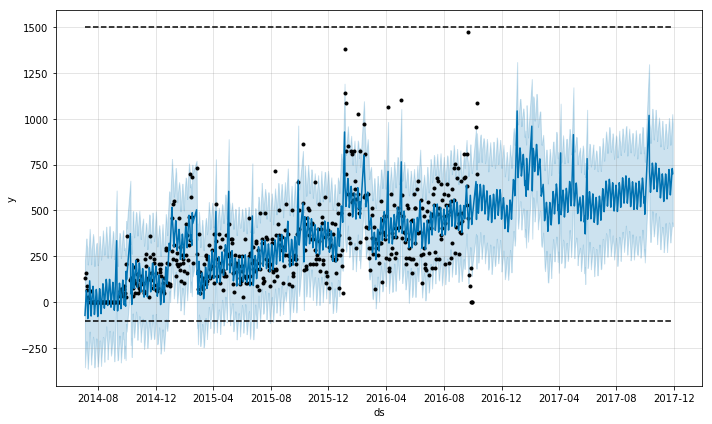

In [100]:
print(forcast_brand5_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand5_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand5_workday.ds < '2016-01-10') & (forcast_brand5_workday.ds > '2016-01-01')])
m_brand5_workday.plot(forcast_brand5_workday)

In [101]:
brand5_result = pd.concat([forcast_brand5_workday, forcast_brand5_restday])
brand5_result = brand5_result.sort_values(by='ds', ascending=True)
print(brand5_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

            ds        yhat  yhat_lower   yhat_upper
766 2017-07-31  637.690072  349.138912   909.290019
767 2017-08-01  613.185842  318.557282   900.753490
768 2017-08-02  563.494022  286.136824   835.575853
769 2017-08-03  494.752253  197.892327   788.950978
770 2017-08-04  528.468562  235.974102   801.313108
306 2017-08-05   83.982479   30.161431   138.261041
771 2017-08-07  651.335163  356.406833   934.920255
772 2017-08-08  630.281621  347.710350   884.269523
773 2017-08-09  583.612695  302.604378   869.268938
774 2017-08-10  517.384245  225.259352   802.173761
775 2017-08-11  553.038659  288.804731   832.690994
307 2017-08-12   86.726055   31.972529   142.942303
776 2017-08-14  677.882418  383.806938   946.903381
777 2017-08-15  656.174767  362.999869   918.844942
778 2017-08-16  608.224885  339.610773   899.377095
779 2017-08-17  540.132741  275.100908   820.279775
780 2017-08-18  573.400206  301.569794   840.151724
308 2017-08-19   89.328247   36.419834   140.841323
781 2017-08-

In [103]:
#将分品牌预测出来的结果合并
def fillPredictResult(df_test_data, df_fill_data, brand):
    df_test_data['predict_result'][df_test_data.brand == brand] = df_fill_data['yhat'].values
    return df_test_data

test_data['predict_result'] = 10
test_data = fillPredictResult(test_data, brand1_result[(brand1_result.ds < '2017-11-29') & (brand1_result.ds > '2016-10-11')], 1)
test_data = fillPredictResult(test_data, brand2_result[(brand2_result.ds < '2017-11-29') & (brand2_result.ds > '2016-10-11')], 2)
test_data = fillPredictResult(test_data, brand3_result[(brand3_result.ds < '2017-11-29') & (brand3_result.ds > '2016-10-11')], 3)
test_data = fillPredictResult(test_data, brand4_result[(brand4_result.ds < '2017-11-29') & (brand4_result.ds > '2016-10-11')], 4)
test_data = fillPredictResult(test_data, brand5_result[(brand5_result.ds < '2017-11-29') & (brand5_result.ds > '2016-10-11')], 5)
test_data = fillPredictResult(test_data, brand6_result[(brand6_result.ds < '2017-11-29') & (brand6_result.ds > '2016-10-11')], 6)
brand7_result = brand7_result.drop_duplicates(['ds'])
test_data = fillPredictResult(test_data, brand7_result[(brand7_result.ds < '2017-11-29') & (brand7_result.ds > '2016-10-11')], 7)
test_data = fillPredictResult(test_data, brand8_result[(brand8_result.ds < '2017-11-29') & (brand8_result.ds > '2016-10-11')], 8)
test_data = fillPredictResult(test_data, brand9_result[(brand9_result.ds < '2017-11-29') & (brand9_result.ds > '2016-10-11')], 9)
test_data = fillPredictResult(test_data, brand10_result[(brand10_result.ds < '2017-11-29') & (brand10_result.ds > '2016-10-11')], 10)
# print(len(test_data['predict_result'][test_data.brand == 7]))
# print(len(brand7_result[(brand7_result.ds < '2016-10-12') & (brand7_result.ds > '2016-05-04')]))
print(test_data[['ds', 'brand', 'day_of_week', 'date', 'predict_result']].head(100))

           ds  brand  day_of_week  date  predict_result
0  2016-10-12      1            3  1250      415.650095
1  2016-10-12      2            3  1250      334.201750
2  2016-10-12      3            3  1250      342.274661
3  2016-10-12      4            3  1250      524.461238
4  2016-10-12      5            3  1250      551.600503
5  2016-10-12      6            3  1250      340.185798
6  2016-10-12      7            3  1250      383.380294
7  2016-10-12      8            3  1250      515.829698
8  2016-10-12      9            3  1250      933.725529
9  2016-10-12     10            3  1250      429.529246
10 2016-10-13      1            4  1251      357.731045
11 2016-10-13      2            4  1251      266.599554
12 2016-10-13      3            4  1251      277.198399
13 2016-10-13      4            4  1251      406.923399
14 2016-10-13      5            4  1251      485.331358
15 2016-10-13      6            4  1251      293.522222
16 2016-10-13      7            4  1251      336

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [107]:
test_data['predict_result'] = test_data['predict_result'].map(lambda x: x if x >=5 else 10)
print(test_data[['date','brand', 'predict_result']][test_data.predict_result == 10].head(10))

      date  brand  predict_result
520   1306      6            10.0
695   1327      4            10.0
696   1327      6            10.0
697   1327      9            10.0
929   1352     10            10.0
1440  1409      6            10.0
1442  1409      9            10.0
1443  1409     10            10.0
1608  1428     10            10.0
1668  1435      4            10.0


In [108]:
# 导出预测结果
def exportResult(df, fileName):
    df.to_csv('./%s.txt' % fileName, sep='\t', header=False, index=False)

#保存预测结果
exportResult(test_data[['date','brand', 'predict_result']], 'prophet_dateProperty_B_fusai_3_7')